# CSE 252B: Computer Vision II, Winter 2018 – Assignment 2
### Instructor: Ben Ochoa
### Due: Wednesday, February 7, 2018, 11:59 PM

## Instructions
* Review the academic integrity and collaboration policies on the course website.
* This assignment must be completed individually.
* This assignment contains both math and programming problems.
* All solutions must be written in this notebook
* Math problems must be done in Markdown/LATEX. Remember to show work and describe your solution.
* Programming aspects of this assignment must be completed using Python in this notebook.
* This notebook contains skeleton code, which should not be modified (This is important for standardization to facilate effeciant grading).
* You may use python packages for basic linear algebra, but you may not use packages that directly solve the problem. Ask the instructor if in doubt.
* You must submit this notebook exported as a pdf. You must also submit this notebook as an .ipynb file.
* You must submit both files (.pdf and .ipynb) on Gradescope. You must mark each problem on Gradescope in the pdf.
* It is highly recommended that you begin working on this assignment early.

## Problem 1 (Programing):  Linear estimation of the camera projection matrix (15 points)
  Download input data from the course website.  The file
  hw2_points3D.txt contains the coordinates of 50 scene points
  in 3D (each line of the file gives the $\tilde{X}_i$, $\tilde{Y}_i$,
  and $\tilde{Z}_i$ inhomogeneous coordinates of a point).  The file
  hw2_points2D.txt contains the coordinates of the 50
  corresponding image points in 2D (each line of the file gives the
  $\tilde{x}_i$ and $\tilde{y}_i$ inhomogeneous coordinates of a
  point).  The scene points have been randomly generated and projected
  to image points under a camera projection matrix (i.e., $\boldsymbol{x}_i
  = \boldsymbol{P} \boldsymbol{X}_i$), then noise has been added to the image point
  coordinates.

  Estimate the camera projection matrix $\boldsymbol{P}_\text{DLT}$ using the
  direct linear transformation (DLT) algorithm (with data
  normalization).  You must express $\boldsymbol{x}_i = \boldsymbol{P} \boldsymbol{X}_i$
  as $[\boldsymbol{x}_i]^\perp \boldsymbol{P} \boldsymbol{X}_i = \boldsymbol{0}$ (not
  $\boldsymbol{x}_i \times \boldsymbol{P} \boldsymbol{X}_i = \boldsymbol{0}$), where
  $[\boldsymbol{x}_i]^\perp \boldsymbol{x}_i = \boldsymbol{0}$, when forming the
  solution. Return
  $\boldsymbol{P}_\text{DLT}$, scaled such that
  $||\boldsymbol{P}_\text{DLT}||_\text{Fro} = 1$
  
  ============================================================================================
  
  $\boldsymbol{Solution}$
  
  Points in 3D space are projected onto the image plane by the equation $x_{i} = PX_{i}$ 
  where $x_{i}$, $X_{i}$ are in the homogeneous vector form. In order to go about solving this
  we first have to normalize both the 2D and 3D coordinates. This is in order so that all
  parameters are in the same order of range and centered. Centering can be done by subtracting
  the mean and range can be altered by scaling. This gives us $x_{i_{DN}} = Tx_{i}$ and
  $X_{i_{DN}} = UX_{i}$. 
  
  Now the projection equation could be represented as $[x_{i}]^\perp PX_{i} = 0$ where $[x_{i}]^\perp x_{i} = 0$, 
  that is is the left null space of $x_{i}$ and we can find it using the House Holder Matrix. 
  This equation could be rewritten as $([x_{i}]^\perp \otimes X_{i})p = 0$ where p is vector representation of 
  projection matrix P.
  
  The projection matrix has 12 elements but only 11 DOF. Each coordinate point gives two equations,
  so we need a minimum of 5.5 or 6 points to solve for p. Given n coordinates we can construct the
  matrix A (size 2n ∗ 12) of kronecker products with Ap = 0. After computing the matrix A, we know
  that p is the null space of matrix A. We can compute this by single value decomposition of A.
  
  $A = UDV^{T}$
  
  and p is the last column of V. We can reshape the p vector to get P. To get back the 
  denormalized matrix, we transform P as $P_{DN} =T^{-1}P_{DN}U$. Taking the forbenious norm of
  $P_{DN}$ will give us $P_{DLT}$.

x is (2, 50)
X is (3, 50)
P_DLT =
[[ -6.03053699e-03   4.88090849e-03  -8.83448329e-03  -8.39604704e-01]
 [ -9.11953829e-03   2.31122411e-03   6.19815234e-03  -5.42952306e-01]
 [ -5.00105053e-06  -4.47147499e-06  -2.55045867e-06  -1.25300059e-03]]
||P_DLT||=1.000000


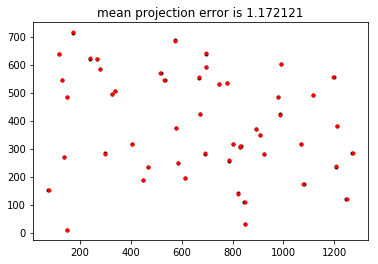

In [276]:
import numpy as np
import matplotlib.pyplot as plt

x=np.loadtxt('hw2_points2D.txt').T
X=np.loadtxt('hw2_points3D.txt').T
print('x is', x.shape)
print('X is', X.shape)

def toHomo(x):
    # converts points from inhomogeneous to homogeneous coordinates
    return np.vstack((x,np.ones((1,x.shape[1]))))

def fromHomo(x):
    # converts points from homogeneous to inhomogeneous coordinates
    return x[:-1,:]/x[-1,:]

def normalize(x):
    dim = x.shape[0]
    # Shift centroid to origin
    m = x.mean(axis=1)
    if dim==3:
        tx = np.array([[1, 0, -m[0]], [0, 1, -m[1]], [0, 0, 1]])
    elif dim==4:
        tx = np.array([[1, 0, 0, -m[0]], [0, 1, 0, -m[1]], [0, 0, 1, -m[2]], [0, 0, 0, 1]])
    
    # Apply translation
    x = tx.dot(x)
    
    # Calculate scaling factor
    var = 0.0
    for i in range(x.shape[1]):
        var+= np.cov(x[:,i])
    s = np.sqrt((x.shape[1]-1)/var)
    #s = np.sqrt((x.shape[1]-1)/np.sum(x.var(axis=1)))
    if dim==3:
        sx = np.array([[s, 0, 0], [0, s, 0], [0, 0, 1]])
    elif dim==4:
        sx = np.array([[s, 0, 0, 0], [0, s, 0, 0], [0, 0, s, 0], [0, 0, 0, 1]])
    
    # Apply scaling
    x = sx.dot(x)
    
    # return normalized coordinate and transformation matrix
    return x, sx.dot(tx)

def householder(x):
    xp = np.zeros((x.shape[1],x.shape[0]-1,x.shape[0]))
    e1 = np.zeros((x.shape[0],1))
    e1[0] = 1.0
    for i in range(x.shape[1]):
        sign = 1 if x[0,i]>=0 else -1
        v = x[:,i].reshape(x.shape[0],1)+sign*np.linalg.norm(x[:,i],2)*e1
        I = np.eye(x.shape[0])
        hv = I - 2*(v.dot(v.T))/(v.T.dot(v))
        xp[i,:,:] = hv[1:,:]
    return xp

def computeP_DLT(x,X):
    # inputs:
    # x 2D points
    # X 3D points
    # output:
    # P_DLT the (3x4) DLT estimate of the camera projection matrix
    
    """your code here"""
    # Convert points to homogeneous space for further processing
    xh = toHomo(x)
    Xh = toHomo(X)
    
    # Normalized the data
    xn, T = normalize(xh)
    Xn, U = normalize(Xh)
    
    # Find orthogonal coordinates rather than taking cross product
    xp = householder(xn)
    
    # Construct 2nx12 matrix A    
    A = []
    for i in range(0,X.shape[1]):
        a,b,c,p,q,r = xp[i,:,:].flatten()
        xx, yy, zz, ww = Xn[:,i]
        
        # From [xi]⊥PXi=0
        A.append([a*xx, a*yy, a*zz, a*ww, b*xx, b*yy, b*zz, b*ww, c*xx, c*yy, c*zz, c*ww])
        A.append([p*xx, p*yy, p*zz, p*ww, q*xx, q*yy, q*zz, q*ww, r*xx, r*yy, r*zz, r*ww])
        
    A = np.asarray(A).squeeze()
    
    # SVD decomposition for solution
    X, D, Vt = np.linalg.svd(A)
    V = Vt.T
    P = V[:,-1].reshape(3,4)
    
    # Denormalization to convert back to original space
    P_DN = np.linalg.pinv(T).dot((P).dot(U))
    return P_DN/np.sqrt(np.sum(P_DN**2)), P


def proj(P,X):
    # projects 3d points X to 2d using projection matrix P
    return fromHomo(np.matmul(P,toHomo(X)))
    
def rmse(x,y):
    # calculates the root mean square error (RMSE)
    # used to measure reprojection error
    return np.mean(np.sqrt(np.sum((x-y)**2,0)))
    
def displayResults(P, x, X, title):
    print (title+' =')
    print (P)
    print ('||%s||=%f'%(title, np.sqrt(np.sum(P**2)) ))

    x_proj = proj(P,X)
    plt.plot(x[0,:], x[1,:],'.k')
    plt.plot(x_proj[0,:], x_proj[1,:],'.r')
    for i in range(x.shape[1]):
        plt.plot([x[0,i], x_proj[0,i]], [x[1,i], x_proj[1,i]], '-r')
    
    plt.title('mean projection error is %f'%rmse(x,x_proj))
    plt.show()

P_DLT, P_N = computeP_DLT(x,X)
displayResults(P_DLT, x, X, 'P_DLT')


## Problem 2 (Programing):  Nonlinear estimation of the camera projection matrix (30 points)
  Use $\boldsymbol{P}_\text{DLT}$ as an initial estimate to an iterative
  estimation method, specifically the Levenberg-Marquardt algorithm,
  to determine the Maximum Likelihood estimate of the camera
  projection matrix that minimizes the projection error.  You must
  parameterize the camera projection matrix as a parameterization of
  the homogeneous vector $\boldsymbol{p} = vec{(\boldsymbol{P}^\top)}$.  It is
  highly recommended to implement a parameterization of homogeneous
  vector method where the homogeneous vector is of arbitrary length,
  as this will be used in following assignments.
  Return $\boldsymbol{P}_\text{LM}$, scaled such that $||\boldsymbol{P}_\text{LM}||_\text{Fro} = 1$.
  You may need to change the max itterations or implement another stoping criteria.
  
  ===================================================================================================
  
  $\boldsymbol{Solution}$
  
  After computing an initial linear estimate of the projection matrix, we now use the Levenberg- 
  Marquardt algorithm to derive a better nonlinear estimate. The value computed in linear estimation
  is used as the initial guess for Levenberg-Marquardt (LM) algorithm. The algorithm is run with an
  initial $\lambda$ value of 0.001 and a convergence tolerance $\eta$ of $10^{-6}$. At each iteration we 
  compute the error vector $\epsilon$ and cost value $\epsilon^{T}\Sigma_{x}^{-1}\epsilon$, where 
  $\epsilon = X_{measurement} - X_{estimated}$,  $X_{measurement}$ is the normalized homogenous input 2D 
  coordinates and $X_{estimated}$ is their estimated values using camera projection matrix.
  
  For LM algorithm, we parameterize the projection matrix to get parameter vector p of 11 elements 
  as the P matrix has 11 DoF. For each optimization iteration, we calculate 
  $\delta = (J^T\Sigma_{x}^{-1}J)^{-1}J^T\Sigma_{x}^{-1}\epsilon$ where J is the Jacobian $J = dX_{measurement}/dp$
  calculated using the chain rule. At each iteration the new parameterized vector is $p_{new} = \delta + p$.
  If cost for $p_{new}$ is less than cost for p we update $p = p_{new}$ and $\lambda = 0.1 ∗ \lambda$; 
  otherwise we increase value of $\lambda$, setting $\lambda = 10 ∗ \lambda$. I have plotted the graph for cost vs iterations 
  at the end. The graph shows that the cost decreases sharply in the first iteration and smooths out thereafter.
  The initial cost after Linear Estimation is 84.44180181, after first iteration its 83.52424336, and
  finally becomes 83.51047354.  

iter 1 mean reprojection error 1.160847
iter 1 cost 83.524243
iter 2 mean reprojection error 1.158908
iter 2 cost 83.510474


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in multiply


iter 3 mean reprojection error 1.158908
iter 3 cost 83.510474
P_LM =
[[  6.06552021e-03  -4.81660824e-03   8.81027954e-03   8.41443212e-01]
 [  9.07235110e-03  -2.30117784e-03  -6.16626306e-03   5.40100482e-01]
 [  4.97891804e-06   4.44129098e-06   2.53304663e-06   1.24643775e-03]]
||P_LM||=1.000000


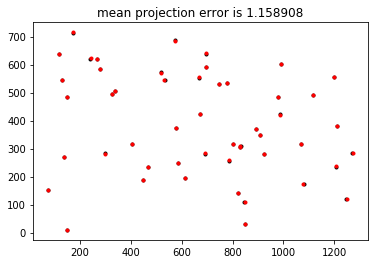

In [280]:
def sinc(x):
    if x==0:
        return 1.0
    else:
        return np.sin(x)/x
    
def error(x_meas, x_est):
    return x_meas-x_est

def calcCost(error, cov_inv):
    return error.T.dot(cov_inv.dot(error))
    
def jacobian(x, X, P):
    p = parameterize(P)
    pn = np.linalg.norm(p,2)
    if pn==0:
        da = np.zeros((1,p.shape[0]))
        db = 0.5*np.eye(p.shape[0])
    else:
        da = -0.5*deparameterize(p)[1:].T 
        db = 0.5*sinc(pn/2)*np.eye(p.shape[0])+1.0/(4.0*pn)*(np.cos(pn/2)/(pn/2)-np.sin(pn/2)/(pn/2)**2)*p.dot(p.T)
    dpdv = np.concatenate((da,db),axis=0)
    J = np.zeros((2*x.shape[1],p.shape[0]))
    for i in range(x.shape[1]):
        w = P[2,:].dot(X[:,i])
        dxdv = 1.0/w*np.array([[X[0,i], X[1,i], X[2,i], X[3,i], 
                      0, 0, 0, 0, 
                      -x[0,i]*X[0,i], -x[0,i]*X[1,i], -x[0,i]*X[2,i], -x[0,i]*X[3,i]],
                      [X[0,i], X[1,i], X[2,i], X[3,i], 
                      0, 0, 0, 0, 
                      -x[1,i]*X[0,i], -x[1,i]*X[1,i], -x[1,i]*X[2,i], -x[1,i]*X[3,i]]]).reshape(2,-1)
        # chain rule
        J[[2*i,2*i+1],:] = dxdv.dot(dpdv)
    return J

def parameterize(x):
    x = x.flatten()
    x /= np.linalg.norm(x,2)
    a = x[0]
    b = x[1:]
    v = 2.0/sinc(np.arccos(a))*b
    vn = np.linalg.norm(v,2)
    if vn>np.pi:
        v = (1-2*np.pi/vn*np.ceil((vn-np.pi)/(2*np.pi)))*v
    return v.reshape(-1,1)

def deparameterize(v):
    p = np.zeros((v.squeeze().shape[0]+1,1))
    vn = np.linalg.norm(v,2)
    p[0] = np.cos(vn/2)
    p[1:] = sinc(vn/2)/2*v
    return p

def parNorm(v):
    vn = np.linalg.norm(v,2)
    if vn>np.pi:
        v = (1-2*np.pi/vn*np.ceil((vn-np.pi)/(2*np.pi)))*v
    return v.reshape(-1,1)

def LMstep(P, x, X, l, v):
    # inputs:
    # P current estimate of P
    # x 2D points
    # X 3D points
    # l LM lambda parameter
    # v LM change of lambda parameter
    # output:
    # P updated by a single LM step
    # l accepted lambda parameter
    
    """your code here"""
    counter=0
    while(counter<1000):
        counter+=1
        # Calculate current error and cost
        x_estimated = proj(P,fromHomo(X)).T.flatten().reshape(-1,1)
        err = error(x_measured,x_estimated)
        cost = calcCost(err,cov_inv)
        # Calculate jacobian
        J = jacobian(x, X, P)
        subterm1 = J.T.dot(cov_inv.dot(J))
        term1 = np.linalg.inv(subterm1+l*np.eye(subterm1.shape[0]))
        term2 = J.T.dot(cov_inv.dot(err))
        # Parameter update value
        delta = term1.dot(term2)
        p = parameterize(P)
        p_new = parNorm(p + delta)
        # Trying to reproject to check new cost
        P_new = deparameterize(p_new).reshape(3,4)
        x_estimated = proj(P_new,fromHomo(X)).T.flatten().reshape(-1,1)
        err = error(x_measured,x_estimated)
        cost_new = calcCost(err,cov_inv)
        if cost_new<cost:
            return P_new, l/v, err, cost_new
        else:
            l = l*v
    return P, l, err, cost

# use P_DLT as an initalization for LM
P_LM = P_N.copy()

# LM hyperparameters
l=0.001
eta = 10**-6 # for stopping
v=10
max_iters=10

# Data Normalization
xn, T = normalize(toHomo(x))
xin = fromHomo(xn)
Xn, U = normalize(toHomo(X))

# Initial cost
x_measured = xin.T.flatten().reshape(-1,1)
x_estimated = proj(P_LM,fromHomo(Xn)).T.flatten().reshape(-1,1)
p = parameterize(P_LM)
scale = T[0,0]**2
cov = scale*np.eye(x_measured.shape[0])
cov_inv = np.linalg.inv(cov)
err = error(x_measured,x_estimated)
cost = calcCost(err,cov_inv)
P_LM = -1*P_LM

costs = []
costs.append(cost)

prev_cost = cost+1

# LM optimization loop
it = 0
while prev_cost-cost>eta:
    prev_cost = cost
    P_LM, l, err, cost = LMstep(P_LM, xin, Xn, l, v)
    P_LMDN = (np.linalg.pinv(T).dot(P_LM)).dot(U)
    P_LMDN = P_LMDN/np.sqrt(np.sum(P_LMDN**2))
    costs.append(cost)
    print ('iter %d mean reprojection error %f'%(it+1, rmse(x,proj(P_LMDN,X))))
    print ('iter %d cost %f'%(it+1, cost))
    it+=1
    
displayResults(P_LMDN, x, X, 'P_LM')

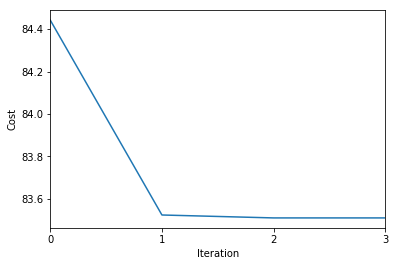

In [281]:
costs = np.asarray(costs).squeeze()
plt.plot(costs)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.xlim([0,costs.shape[0]-1])
plt.xticks([i for i in range(costs.shape[0])])
plt.show()

In [282]:
costs

array([ 84.44180181,  83.52424336,  83.51047354,  83.51047354])